<a href="https://colab.research.google.com/github/DaveStutler/G9/blob/Darian/TEAM_FRIENDSHIP_PARTICLES_WOOOOO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 2 - MODELS
note: if you are confused about how we obtained holygrail.csv, see part one

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy import sparse
from scipy.sparse import csr_matrix
import pandas as pd
import numpy
import matplotlib.pyplot as plt

In [ ]:
# get our (partially) preprocessed data
holygrail = pd.read_csv('/content/holygrail.csv')

In [7]:
# we will need these too
tree_names = ['dEdx_PionPlus_Isolated;1', 'dEdx_PionMinus_Isolated;1', 'dEdx_KaonPlus_Isolated;1',
'dEdx_KaonMinus_Isolated;1',
'dEdx_ProtonPlus_Isolated;1',
'dEdx_ProtonMinus_Isolated;1',
'dEdx_DeuteronPlus_Isolated;1',
'dEdx_DeuteronMinus_Isolated;1',
'dEdx_TritonPlus_Isolated;1',
'dEdx_HelionPlus_Isolated;1',
'dEdx_HelionMinus_Isolated;1',
'dEdx_AlphaPlus_Isolated;1',
'dEdx_AlphaMinus_Isolated;1']

In [8]:
#splitting the data and normalizing

#NOTE: this code normalizes linear and circular elements seperately. See discord https://discord.com/channels/1139651953937358888/1139651954675568709/1146933407704690814
# for explaination
target_columns = ['linear', 'circular']
other_columns = holygrail.columns[:-2]
temp, test = train_test_split(holygrail, test_size=0.2, random_state=12, shuffle=True)
train, validate = train_test_split(holygrail, test_size=0.1, random_state=12, shuffle=True)

# 70% training data, 20% testing data and 10% validation data

In [ ]:

# to normalize the train and test sets seprately to avoid data leakage
# We need to include both the X and the y values when we normalize to ensure we are normalizing seprately based
# on the different collider shapes in order to account for a difference in the sample size for each
# we will detele the labels from X train and test as soon as we normalize

import random

threshold = .02 #To get rid of noise in the data.



def normalizer(df):
  #print(df.columns)
  linear_rows = df[df['linear'] == 1].copy()
  circle_rows = df[df['circular'] == 1].copy()

  for column in df.columns:
      if column in ['linear', 'circular']:
        continue
      else:
        column_datal = linear_rows[column]
        maximl = column_datal.max()
        miniml = column_datal.min()
        linear_rows.loc[:, column] = np.where(
            (column_datal - miniml) / (maximl - miniml) > 0,
            (column_datal - miniml) / (maximl - miniml),
            0) #no need to threshold here

        column_datac = circle_rows[column]
        maximc = column_datac.max()
        minimc = column_datac.min()
        circle_rows.loc[:, column] = np.where(
            (column_datac - minimc) / (maximc - minimc) > threshold,
            (column_datac - minimc) / (maximc - minimc),
            0)
        # mix all the linear and circular rows together so that the data is more randomized
        # we are also making sure the counts of each are the same
  columns_to_check = tree_names
  filtered_linear_rows = linear_rows[(linear_rows[columns_to_check] >.005).any(axis=1)] #we are only including rows where there is data for at least one
  #of our features

  filtered_circular_rows = circle_rows[(circle_rows[columns_to_check] >.005).any(axis=1)]

  # make sure there is the same number so that there is no bias in the model
  min_num = min(len(filtered_linear_rows), len(filtered_circular_rows))
  sampled_linear_rows = filtered_linear_rows.sample(n=min_num, random_state=12)
  sampled_circular_rows = filtered_circular_rows.sample(n=min_num, random_state=12)
  print(len(sampled_linear_rows))
  print(len(sampled_circular_rows))
  mixed_rows = pd.concat([sampled_circular_rows, sampled_linear_rows], ignore_index=True)

  mixed_rows = mixed_rows.sample(frac=1, random_state=42).reset_index(drop=True)
  return mixed_rows


norm_train = normalizer(train)
norm_test = normalizer(test)
norm_val = normalizer(validate)




# Making sure our training and testing sets have similar corrilations as the full data
We need to do this since our mormalizer takes a random sample, so we want to make sure the samples have representitive correlations to the full data

<Axes: >

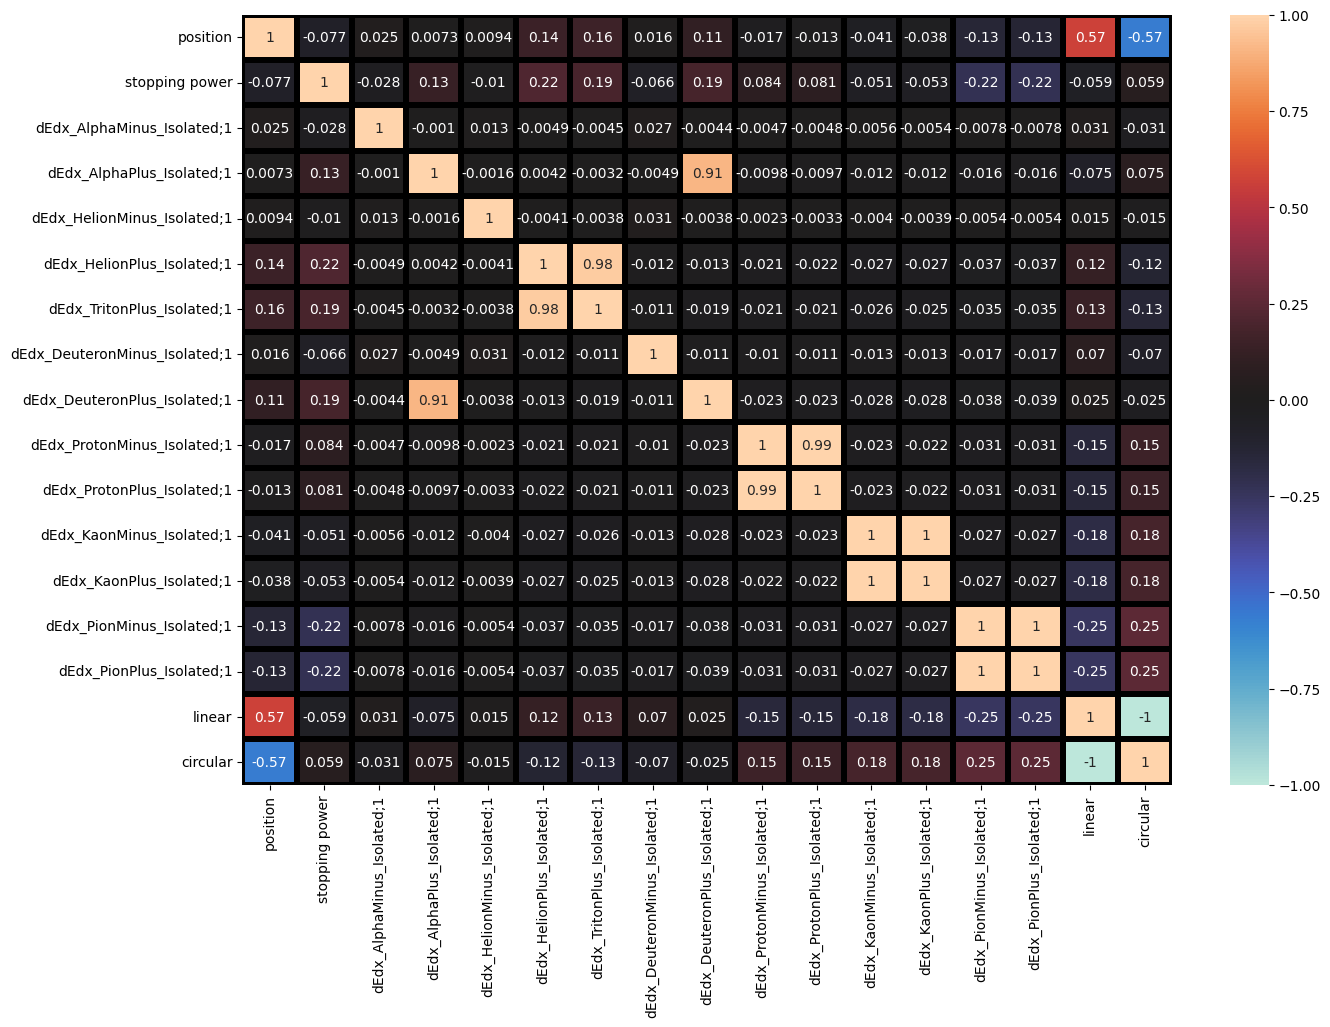

In [ ]:
# FULL DATA DISTRIBUTION
plt.rcParams['figure.figsize'] = (15.0, 10.0)
sns.heatmap(holygrail.corr(), annot = True, vmin = -1, vmax = 1, center = 0, linewidth= 3, linecolor = 'black', )

<Axes: >

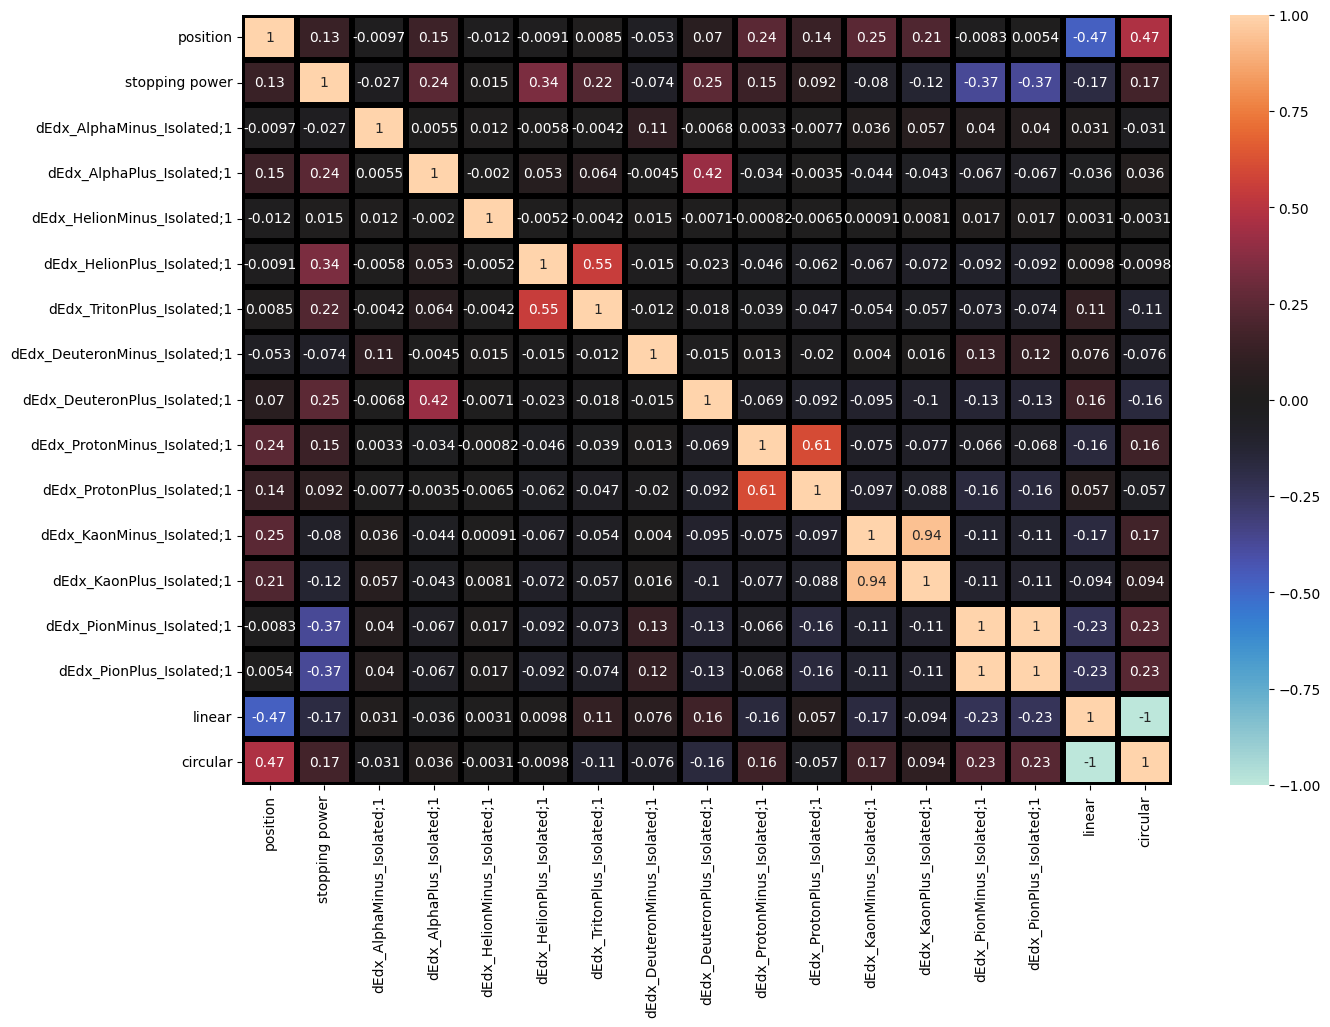

In [ ]:
# TRAINING DISTRIBUTION
plt.rcParams['figure.figsize'] = (15.0, 10.0)
sns.heatmap(norm_train.corr(), annot = True, vmin = -1, vmax = 1, center = 0, linewidth= 3, linecolor = 'black', )


<Axes: >

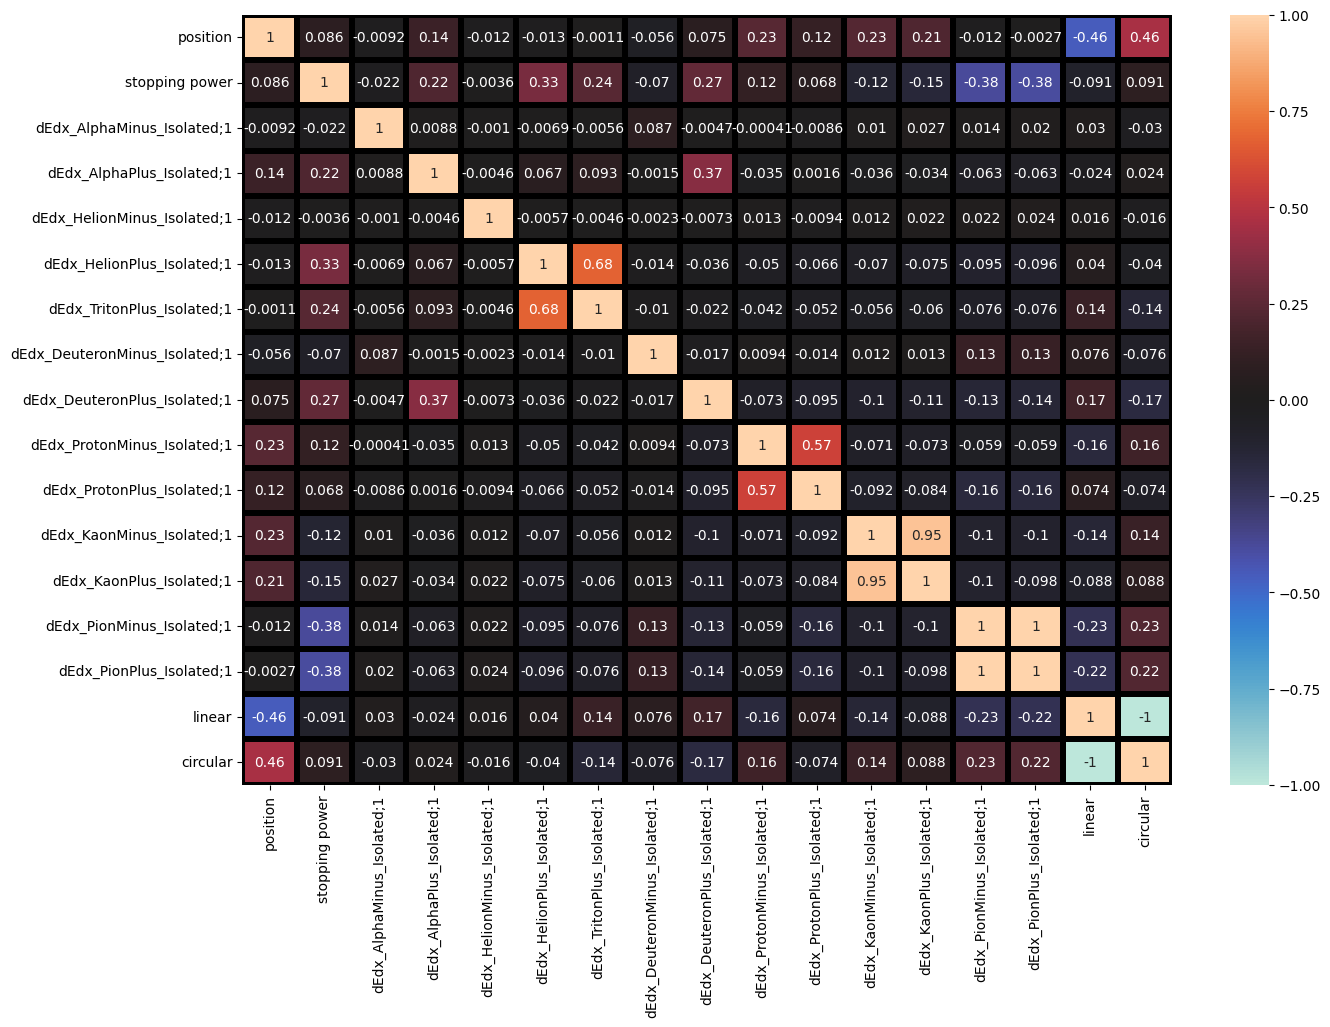

In [ ]:
# TESTING DISTRIBUTION
plt.rcParams['figure.figsize'] = (15.0, 10.0)
sns.heatmap(norm_test.corr(), annot = True, vmin = -1, vmax = 1, center = 0, linewidth= 3, linecolor = 'black', )


while the exact corrilation values are not exactly the same, the locations of the strongly corrilated values are consistant across both the testing, training, and overall dataset

<Axes: >

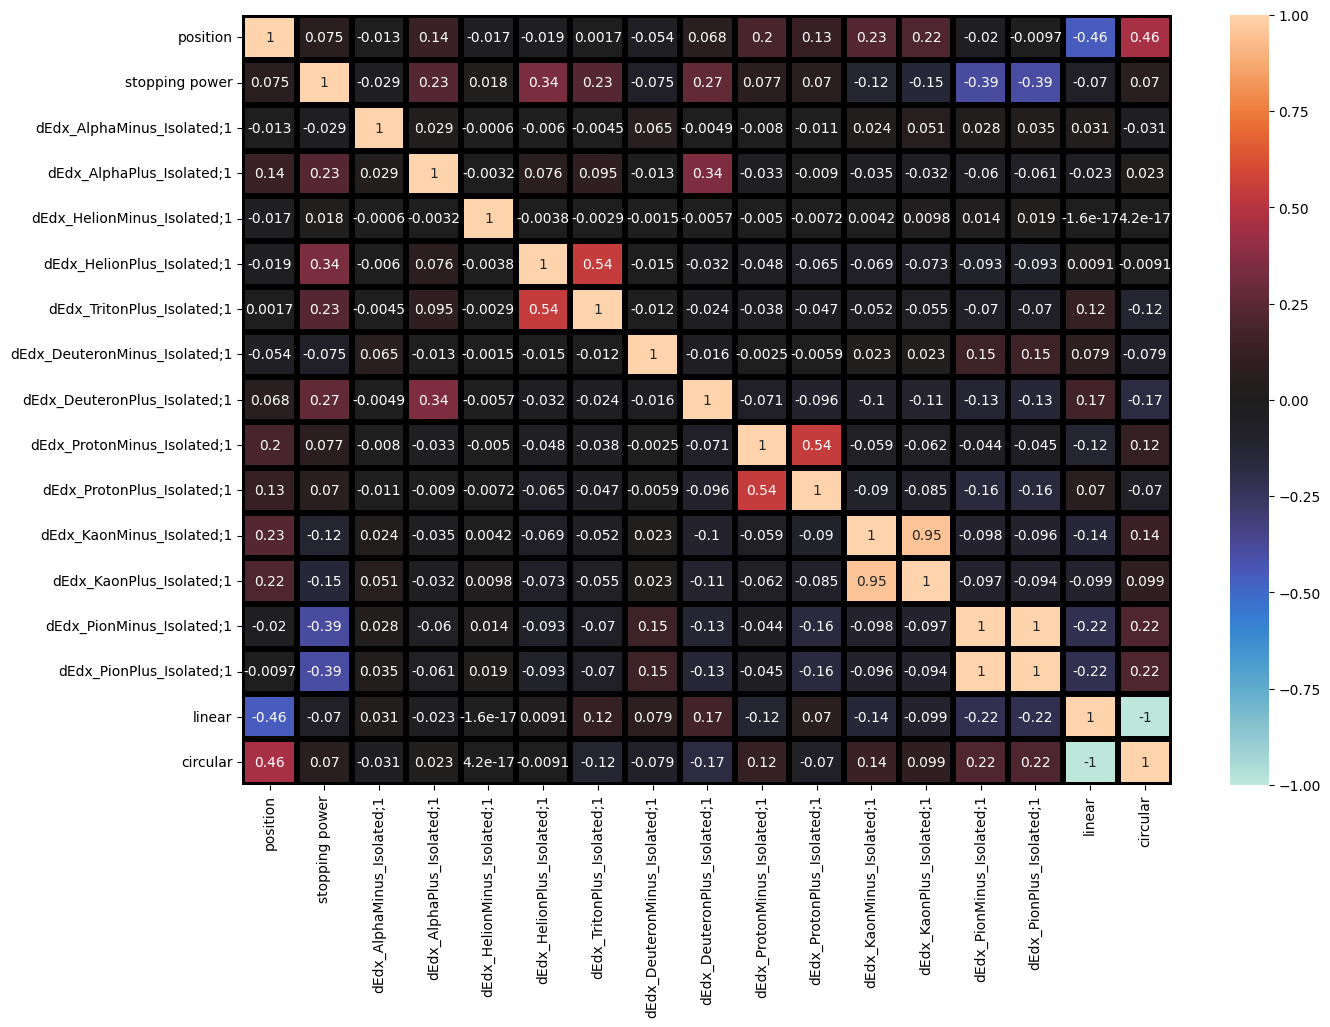

In [ ]:
# validation data
plt.rcParams['figure.figsize'] = (15.0, 10.0)
sns.heatmap(norm_val.corr(), annot = True, vmin = -1, vmax = 1, center = 0, linewidth= 3, linecolor = 'black', )

#also a good representation

# Now we are going to start making our models!

# SUPERVIZED NEURAL NETS

# Model 1: Binary Classification - Linear vs. Circular Collisions



In [ ]:
# installations and imports

!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.model_selection import KFold
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier #getting weird error
from tensorflow.keras import optimizers
from sklearn.model_selection import cross_val_score, cross_validate


In [ ]:
# split the data so that y contains the collider type
X_train = norm_train.drop(['linear', 'circular'], axis = 1)
y_train = norm_train[['linear', 'circular']]

X_test = norm_test.drop(['linear', 'circular'], axis = 1)
y_test = norm_test[['linear', 'circular']]

X_val = norm_val.drop(['linear', 'circular'], axis = 1)
y_val = norm_val[['linear', 'circular']]


In [ ]:
# binary classification model with early stopping and model checkpoint

from sklearn.metrics import accuracy_score, mean_squared_error
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001)
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)






target_columns = ['linear', 'circular']
  #making a new model each time so that it doesn't remember the training or testing data from previous loops
classifier = Sequential()

classifier.add(Dense(units = len(X_train.columns), activation = 'ReLU', input_dim = len(other_columns)))

classifier.add(Dense(units = 12, activation = 'ReLU'))
classifier.add(Dense(units = 12, activation = 'ReLU'))
classifier.add(Dense(units = 12, activation = 'ReLU'))
classifier.add(Dense(units = 12, activation = 'ReLU'))
classifier.add(Dense(units = 12, activation = 'ReLU'))
classifier.add(Dense(units = 12, activation = 'ReLU'))
classifier.add(Dense(units = 12, activation = 'ReLU'))
classifier.add(Dense(units = 6, activation = 'ReLU'))
classifier.add(Dense(units = 6, activation = 'ReLU'))
classifier.add(Dense(units = 2, activation = 'sigmoid'))


classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = classifier.fit(X_train, y_train, batch_size=32, epochs=40, verbose=True, validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint])
# I put epochs = 40, but I highly doubt it will run that long because it will stop as soon as the validation has not improved in 10 epochs








Epoch 1/40
1509/1509 [==============================] - 10s 5ms/step - loss: 0.1876 - accuracy: 0.9176 - val_loss: 0.1984 - val_accuracy: 0.9413
Epoch 2/40
  30/1509 [..............................] - ETA: 5s - loss: 0.0466 - accuracy: 0.9896

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1509/1509 [==============================] - 7s 5ms/step - loss: 0.0410 - accuracy: 0.9865 - val_loss: 0.2659 - val_accuracy: 0.9371
Epoch 3/40
1509/1509 [==============================] - 7s 4ms/step - loss: 0.0324 - accuracy: 0.9891 - val_loss: 0.3351 - val_accuracy: 0.9291
Epoch 4/40
1509/1509 [==============================] - 7s 4ms/step - loss: 0.0302 - accuracy: 0.9894 - val_loss: 0.3372 - val_accuracy: 0.9330
Epoch 5/40
1509/1509 [==============================] - 7s 5ms/step - loss: 0.0255 - accuracy: 0.9909 - val_loss: 0.2968 - val_accuracy: 0.9383
Epoch 6/40
1509/1509 [==============================] - 7s 5ms/step - loss: 0.0247 - accuracy: 0.9915 - val_loss: 0.2754 - val_accuracy: 0.9448
Epoch 7/40
1509/1509 [==============================] - 7s 4ms/step - loss: 0.0214 - accuracy: 0.9924 - val_loss: 0.4631 - val_accuracy: 0.9242
Epoch 8/40
1509/1509 [==============================] - 7s 5ms/step - loss: 0.0219 - accuracy: 0.9925 - val_loss: 0.3694 - val_accuracy: 0.9387
Epo

In [ ]:
#evaluating
yhat_test = classifier.predict(X_test.astype(float))


yhat_binary = (yhat_test == yhat_test.max(axis=1, keepdims=True)).astype(int)

y_test_values = y_test.values

accuracy = accuracy_score(y_test, yhat_binary)

mse = mean_squared_error(y_test, yhat_test)
stopped_epoch = early_stopping.stopped_epoch

best_val = checkpoint.best
print("We stopped after epoch:", stopped_epoch)
print("Best model saved after epoch:", stopped_epoch -9) # because set our early parameter to stop after there have been no improvements for 8 epochs
print("We stopped when the validation accuracy was:", best_val)
print("MSE is:", mse, '\nOur testing accuracy is:', accuracy)

335/335 [==============================] - 1s 3ms/step
We stopped after epoch: 25
Best model saved after epoch: 16
We stopped when the validation accuracy was: 0.9544761776924133
MSE is: 0.014270015084359749 
Our testing accuracy is: 0.9828101644245142


              precision    recall  f1-score   support

      linear       1.00      0.97      0.98      5352
    circular       0.97      1.00      0.98      5352

    accuracy                           0.98     10704
   macro avg       0.98      0.98      0.98     10704
weighted avg       0.98      0.98      0.98     10704



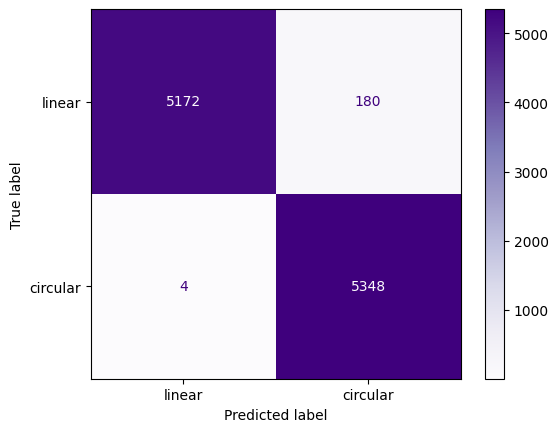

In [ ]:
#displaying the results
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(y_test_values.argmax(axis=1),yhat_binary.argmax(axis=1),target_names=target_columns,digits=2))
matrixim = confusion_matrix(y_test_values.argmax(axis=1), yhat_binary.argmax(axis=1))
mycmdisp = ConfusionMatrixDisplay(confusion_matrix=matrixim, display_labels=target_columns)
mycmdisp.plot(cmap=plt.cm.Purples, values_format='d')

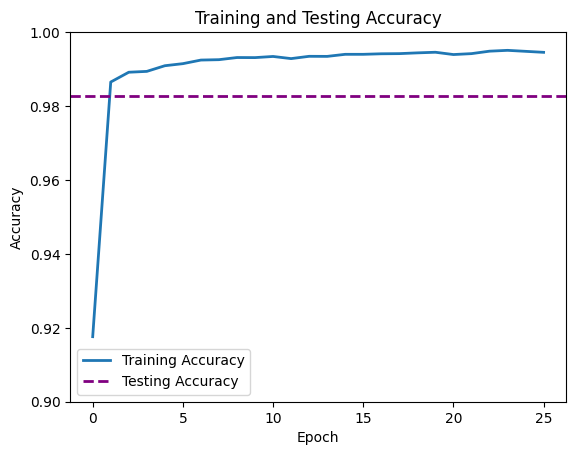

In [ ]:
# fitting graph
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.axhline(y=accuracy, label='Testing Accuracy ', linestyle='--', color = 'purple', linewidth=2)
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.ylim(.9, 1)
# Without this, it makes it look like our testing and training accuracies are super different
# even though in reality they are only .02 apart
plt.legend()
plt.show()



## k-Fold Cross Validation
we will use this to see how consistant our model is

In [ ]:
# To be used to create instances of a DNN Model with the following architecture.
def Create_DNN_Model():
  classifier = Sequential() # Initialising the DNN.

  classifier.add(Dense(units = 12, activation = 'ReLU'))
  classifier.add(Dense(units = 12, activation = 'ReLU'))
  classifier.add(Dense(units = 12, activation = 'ReLU'))
  classifier.add(Dense(units = 12, activation = 'ReLU'))
  classifier.add(Dense(units = 12, activation = 'ReLU'))
  classifier.add(Dense(units = 12, activation = 'ReLU'))
  classifier.add(Dense(units = 12, activation = 'ReLU'))
  classifier.add(Dense(units = 6, activation = 'ReLU'))
  classifier.add(Dense(units = 6, activation = 'ReLU'))
  classifier.add(Dense(units = 2, activation = 'sigmoid'))                                             # Output layer.

  classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return classifier

In [ ]:

kfolds = KFold(n_splits=5, shuffle=True, random_state=12) # k-Fold cross-validation split.
# we will normalize seprately for validation and train.
# NOTE: the exact number of instances for train and val will vary slightly for each split based on how we defined
# the normalizer function to remove all rows where there is no significant data
# the variation will be very small though and should not have a large affect on the accuracy and mse scores

scores = []
for train_index, val_index in kfolds.split(train):
  train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
  train_fold = normalizer(train_fold)
  print('normalized successful for train')
  val_fold = normalizer(val_fold)
  print('normalized successful for val')
  y_train_fold = train_fold[['linear','circular']]
  X_train_fold = train_fold.drop(['linear','circular'], axis = 1)
  X_val_fold = val_fold.drop(['linear','circular'], axis = 1)
  y_val_fold = val_fold[['linear','circular']]
  model = Create_DNN_Model()
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(X_train_fold, y_train_fold, epochs=16, batch_size=32, verbose=0)
  # using the best epoch from last time
  y_val_pred = model.predict(X_val_fold)
  accuracy = accuracy_score(y_val_fold, np.round(y_val_pred))
  scores.append(accuracy)



In [ ]:
scores

[0.9537399546672162,
 0.9606580829756796,
 0.9835313737752762,
 0.9415611376375337,
 0.9274341702388242]

In [ ]:
# A sign that we have a good model is if it can generalize well to unseen data with high consistancy
# because we are testing on new unseen data in each fold, having a high accuracy and low sd would signify that
# we have a highly accurate an consistant model
scores = np.array(scores)
print('\nOverall Average Accuracy: %.3f (sd = %.3f)\n' % (scores.mean(), scores.std()))





Overall Average Accuracy: 0.953 (sd = 0.019)



# Model 2: SVM to predict linear vs circular collider type

In [ ]:
# filtering out the particles with thew highest correlation to the collider type

import pandas as pd

def svm_feature_extractor(df, tar_columns):
    linear_rows = df[df['linear'] == 1]
    circular_rows = df[df['circular'] == 1]

    filtered_linear_rows = pd.DataFrame()
    filtered_circular_rows = pd.DataFrame()

    for col in tar_columns:
        # for now, we are only considering rows where at least one of our target features has a non-zero value
        linear_non_zero = linear_rows[col] != 0
        circular_non_zero = circular_rows[col] != 0

        filtered_linear_rows = filtered_linear_rows.append(linear_rows[linear_non_zero])
        filtered_circular_rows = filtered_circular_rows.append(circular_rows[circular_non_zero])

    # counter for non-zero values in each row
    filtered_linear_rows['non_zero_count'] = (filtered_linear_rows[tar_columns] != 0).sum(axis=1)
    filtered_circular_rows['non_zero_count'] = (filtered_circular_rows[tar_columns] != 0).sum(axis=1)

    # Filtering rows where at least three target columns have non-zero values
    # we do this because we want at least one variable other than position or stopping power to include a non zero value for each row
    filtered_linear_rows = filtered_linear_rows[filtered_linear_rows['non_zero_count'] >= 3].copy()
    filtered_circular_rows = filtered_circular_rows[filtered_circular_rows['non_zero_count'] >= 3].copy()

    # Droping the 'non_zero_count' column
    filtered_linear_rows.drop('non_zero_count', axis=1, inplace=True)
    filtered_circular_rows.drop('non_zero_count', axis=1, inplace=True)

    # to ensure there is the same amount of each
    linear_len = int(filtered_linear_rows.shape[0])
    circular_len = int(filtered_circular_rows.shape[0])
    sample_size = min(linear_len, circular_len)

    sampled_linear_rows = filtered_linear_rows.sample(n=sample_size, random_state=12)
    sampled_circular_rows = filtered_circular_rows.sample(n=sample_size, random_state=12)
    mixed_rows = pd.concat([sampled_circular_rows, sampled_linear_rows], ignore_index=True)
    # distributing the linear and circular rows evenly to prevent bias
    mixed_rows = mixed_rows.sample(frac=1, random_state=12).reset_index(drop=True)
    return mixed_rows

# Example usage:
# filtered_data = svm_feature_extractor(your_dataframe, your_target_columns)


#we choose these due to high corrilation with collider type
target_columns = ['position', 'stopping power', 'dEdx_PionPlus_Isolated;1', 'dEdx_KaonPlus_Isolated;1']
Train = svm_feature_extractor(norm_train, target_columns)
Test = svm_feature_extractor(norm_test, target_columns)



In [102]:
X_train_svm = Train[target_columns]
y_train_svm = Train[['linear', 'circular']]
X_test_svm = Test[target_columns]
y_test_svm = Test[['linear', 'circular']]

In [ ]:
# SVM model for classifying linear vs circular



# Model 3 Regression - Predicting the counts of particles based on the position and stopping power at which they were detected as well as the collider type


## Creating a Regression Model

In [ ]:
X_train = norm_train[['stopping power', 'position', 'circular', 'linear']]
y_train = norm_train.drop(['stopping power', 'position', 'circular', 'linear'], axis=1)

X_val = norm_val[['stopping power', 'position', 'circular', 'linear']]
y_val = norm_val.drop(['stopping power', 'position', 'circular', 'linear'], axis=1)

X_test = norm_test[['stopping power', 'position', 'circular', 'linear']]
y_test = norm_test.drop(['stopping power', 'position', 'circular', 'linear'], axis=1)

In [ ]:
# note, the way the dataframe is formatting is by saying the count of each particle that collided at that stopping power and position
# we want to use this to predict the count of each particle that will be detected at a certain stopping power and position
from sklearn.metrics import accuracy_score, mean_squared_error
from keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from keras.utils import get_custom_objects
from keras.layers import LeakyReLU

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001)
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)



classifier = Sequential()

classifier.add(Dense(units = len(X_train.columns), activation = 'linear', input_dim = len(X_train.columns)))
classifier.add(Dense(units=12, activation=LeakyReLU(alpha=0.01))) # to introduce non linearity
classifier.add(Dense(units=6, activation=LeakyReLU(alpha=0.01)))
classifier.add(Dense(units = len(y_train.columns), activation = 'linear'))
classifier.compile(loss='MSE', optimizer='adam', metrics=['MSE'])


history = classifier.fit(X_train, y_train, batch_size=32, epochs=40, verbose=True, validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint])
# I put epochs = 40, but I highly doubt it will run that long because it will stop as soon as the validation has not improved in 10 epochs





Epoch 1/40
1509/1509 [==============================] - 5s 2ms/step - loss: 0.0122 - MSE: 0.0122 - val_loss: 0.0125 - val_MSE: 0.0125
Epoch 2/40
  49/1509 [..............................] - ETA: 3s - loss: 0.0111 - MSE: 0.0111

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1509/1509 [==============================] - 4s 2ms/step - loss: 0.0100 - MSE: 0.0100 - val_loss: 0.0112 - val_MSE: 0.0112
Epoch 3/40
1509/1509 [==============================] - 4s 3ms/step - loss: 0.0083 - MSE: 0.0083 - val_loss: 0.0132 - val_MSE: 0.0132
Epoch 4/40
1509/1509 [==============================] - 4s 2ms/step - loss: 0.0071 - MSE: 0.0071 - val_loss: 0.0190 - val_MSE: 0.0190
Epoch 5/40
1509/1509 [==============================] - 3s 2ms/step - loss: 0.0063 - MSE: 0.0063 - val_loss: 0.0224 - val_MSE: 0.0224
Epoch 6/40
1509/1509 [==============================] - 4s 2ms/step - loss: 0.0058 - MSE: 0.0058 - val_loss: 0.0227 - val_MSE: 0.0227
Epoch 7/40
1509/1509 [==============================] - 4s 3ms/step - loss: 0.0055 - MSE: 0.0055 - val_loss: 0.0229 - val_MSE: 0.0229
Epoch 8/40
1509/1509 [==============================] - 3s 2ms/step - loss: 0.0052 - MSE: 0.0052 - val_loss: 0.0244 - val_MSE: 0.0244
Epoch 9/40
1509/1509 [==============================] - 3s 2ms/step - los

In [ ]:
yhat_test = classifier.predict(X_test.astype(float))


y_test_values = y_test.values


mse = mean_squared_error(y_test, yhat_test)
stopped_epoch = early_stopping.stopped_epoch
best_val = checkpoint.best
print("We stopped after epoch:", stopped_epoch)
print("Best model saved after epoch:", stopped_epoch -9) # because set our early parameter to stop after there have been no improvements for 8 epochs
print("We stopped when the validation mse was:", best_val)
print("MSE testing is:", mse)

335/335 [==============================] - 1s 2ms/step
We stopped after epoch: 11
Best model saved after epoch: 2
We stopped when the validation mse was: 0.011218510568141937
MSE testing is: 0.006146725842076111


## k-Fold Cross Validation (For Regression)
 NOTE: this has been commented out due to expensive GPU requirements. It is included as a demo for what we could achieve if we had access to a larger GPU


In [ ]:
# To be used to create instances of a DNN Model with the following architecture.
def Create_Regression_Model():
  classifier = Sequential()

  classifier.add(Dense(units = len(X_train.columns), activation = 'linear', input_dim = len(X_train.columns)))
  classifier.add(Dense(units=12, activation=LeakyReLU(alpha=0.01))) # to introduce non linearity
  classifier.add(Dense(units=6, activation=LeakyReLU(alpha=0.01)))
  classifier.add(Dense(units = len(y_train.columns), activation = 'linear'))
  classifier.compile(loss='MSE', optimizer='adam', metrics=['MSE'])

  return classifier

In [ ]:
# Note: in theory this would work, but for now it requires too much GPU
# Also, we do not think it is nessecary since the mse we obtained from the original model was already low
# we still decided to include it as a comment though to include all group members code in the final submission and show that everyone contributed

kfolds = KFold(n_splits=5, shuffle=True, random_state=12) # k-Fold cross-validation split.


mse_scores = []

#I think this isnt working because X_train and y_train are df and not values. I was getting this error on hw2


for train_index, val_index in kfolds.split(train):
  train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
  train_fold = normalizer(train_fold)
  print('normalized successful for train')
  val_fold = normalizer(val_fold)
  print('normalized successful for val')
  y_train_fold = train_fold.drop(['linear','circular', 'position', 'stopping power'], axis = 1)
  X_train_fold = train_fold[['linear','circular', 'position', 'stopping power']]
  y_val_fold = val_fold.drop(['linear','circular', 'position', 'stopping power'], axis = 1)
  X_val_fold = val_fold[['linear','circular', 'position', 'stopping power']]
  model = Create_Regression_Model()
  model.fit(X_train_fold, y_train_fold, epochs=2, batch_size=32, verbose=0)
  #using epochs = 2 because in the previous model we got the best error after 2 epochs
  yhat_test = model.predict(X_val_fold.astype(float))
  mse_val = mean_squared_error(y_val_fold, yhat_test)
  mse_scores.append(round(mse_val, 3))



In [ ]:
print(mse_scores)
print("When validating with 5 random folds, our model achieved a mean loss of {} with sd = {}".format(np.mean(mse_scores),np.std(mse_scores)))

[0.011, 0.01, 0.011, 0.012, 0.011]
When validating with 5 random folds, our model achieved a mean loss of 0.011 with sd = 0.000632455532033676


# UNSUPERVIZED LEARNING -- SYNTHETIC DATA GENERATOR

## Goals:
 - to be able to generate fake data that matches the distribution and is indistinguishable from real data. Due to data complexity, we will only be implimenting this model on a single particle. For this model, we chose 'dEdx_PionPlus_Isolated;1' from the circular collider type data

## Changes we need to make to the data
 - We will need t create a seprate df for this data including only the count of this feature, the position, and the stopping speed


 ## Model
- To generate the synthetic data we will be using an encoder decoder vae model with loss = mse. We will generate 500 new samples

## Testing
- we can test our data visually by seeing where it falls when plotted alongside the population data. We will also test using statistical tests and by using dbscan clustering to see if the points are detected as being in the same cluster

we want to change the formatting to make it look like this:

In [40]:
# preprocessing data to only contain our values of interest.
data = norm_train[(norm_train['circular'] == 1) & (norm_train['dEdx_PionPlus_Isolated;1'] > 0.01)] #making sure we only select columns with meaningful data

new_data = data[['position', 'stopping power', 'dEdx_PionPlus_Isolated;1']]

for col in new_data.columns:
    max_val = new_data[col].max()
    min_val = new_data[col].min()
    new_data[col] = (new_data[col] - min_val) / (max_val - min_val)

new_data.columns = ['position', 'stopping power', 'count']

print(new_data)





        position  stopping power     count
0       0.308176        0.207921  0.423474
1       0.144654        0.198020  0.005819
3       0.867925        0.445545  0.064274
4       0.707547        0.524752  0.341594
14      0.276730        0.287129  0.696655
...          ...             ...       ...
134073  0.927673        0.594059  0.031532
134089  0.455975        0.683168  0.041394
134095  0.411950        0.732673  0.002321
134102  0.556604        0.336634  0.725289
134115  0.742138        0.544554  0.258239

[17481 rows x 3 columns]


<ipython-input-40-3c93fb0da6e4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[col] = (new_data[col] - min_val) / (max_val - min_val)


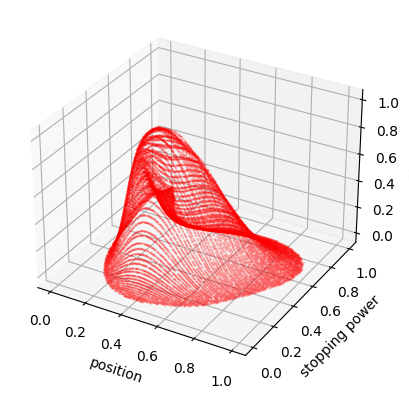

In [41]:
plotter(new_data, 'red') # so we can see what our population distribution looks like

In [13]:
import matplotlib.pyplot as plt
def plotter(df, color): # we will use this function for plotting later on
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(df['position'], df['stopping power'], df['count'], c=color, alpha = .2, s= .5)

  ax.set_xlabel('position')
  ax.set_ylabel('stopping power')
  ax.set_zlabel('count')

  plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
import numpy as np
from keras.layers import LeakyReLU
# our encoder decoder model
def generate_leaky(feature):
        if len(feature) % 2 == 1:
          feature.drop(feature.index[-1], inplace=True)
        train, val = train_test_split(feature, test_size=0.5, random_state=12, shuffle=True)
        plotter(train, 'blue') # making sure our train test split didnt mess up the distribution
        plotter(val, 'purple')
        plotter(new_data, 'red')
        latent_dim = 10 # latent space is a lower-dimensional representation of data that we will be encoding and decoding into
        def mannwhitneyu_loss(y_true, y_pred):
          statistic, p_value = mannwhitneyu(y_true, y_pred)
          loss = 1 - p_value
          return loss

        encoder_input = Input(shape=(3,))
        encoder_output = Dense(5000, activation=LeakyReLU(alpha=0.01))(encoder_input) #parameters set via guess and check for 6 hours
        encoder_output = Dense(5000, activation=LeakyReLU(alpha=0.01))(encoder_input)
        encoder_output = Dense(12, activation=LeakyReLU(alpha=0.01))(encoder_input)
        encoder_output = Dense(12, activation=LeakyReLU(alpha=0.01))(encoder_input)
        encoder_output = Dense(12, activation=LeakyReLU(alpha=0.01))(encoder_input)
        encoder_output = Dense(latent_dim)(encoder_output)
        encoder = tf.keras.Model(encoder_input, encoder_output)

        decoder_input = Input(shape=(latent_dim,))
        decoder_output = Dense(5000, activation=LeakyReLU(alpha=0.01))(decoder_input)
        decoder_output = Dense(5000, activation=LeakyReLU(alpha=0.01))(decoder_input)
        decoder_output = Dense(12, activation=LeakyReLU(alpha=0.01))(decoder_input)
        decoder_output = Dense(12, activation=LeakyReLU(alpha=0.01))(decoder_input)
        decoder_output = Dense(3)(decoder_output)
        decoder = tf.keras.Model(decoder_input, decoder_output)

        vae_input = Input(shape=(3,))
        encoded = encoder(vae_input)
        decoded = decoder(encoded)
        vae = tf.keras.Model(vae_input, decoded)

        vae.compile(optimizer='adam', loss='mse')

        vae.fit(train, val, epochs=150, batch_size=32)
        train_data = train.to_numpy()
        mean_values = np.mean(train_data, axis=0) #set the default to be slightly more similar to the population so the model has to do a bit less work
        std_values = np.std(train_data, axis=0)

        noise = np.random.normal(loc=mean_values, scale=std_values, size=(500, 3)) # making an array of 500 rows that we can update with our model
        latent_representations = encoder.predict(noise)
        predictions = decoder.predict(latent_representations)
        print(predictions)
        return predictions







#print([circle_features[0]])
predictions_leaky = generate_leaky(new_data)


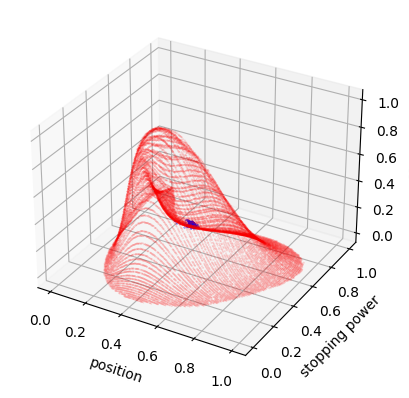

In [93]:
predictions_leaky = pd.DataFrame(data=predictions_leaky, columns=['position', 'stopping power', 'count'])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_data['position'], new_data['stopping power'], new_data['count'], c='red', s = .1, alpha = .2)
ax.scatter(predictions_leaky['position'], predictions_leaky['stopping power'], predictions_leaky['count'], s = .1, c='blue')
ax.set_xlabel('position')
ax.set_ylabel('stopping power')
ax.set_zlabel('count')

plt.show()
# looks pretty good! Our little sample is hugging the population data pretty tightly

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


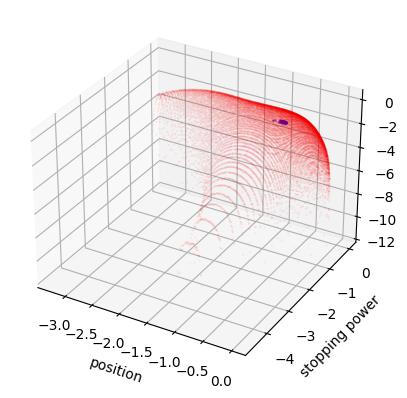

In [94]:
newww1 = pd.DataFrame()
newww2 = pd.DataFrame()
for col in new_data:
  newww1[col] = np.log(new_data[col])
  newww2[col] = np.log(predictions_leaky[col])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newww1['position'], newww1['stopping power'], newww1['count'], c='red', s = .1, alpha = .1)
ax.scatter(newww2['position'], newww2['stopping power'], newww2['count'], s = .1, c='blue')
ax.set_xlabel('position')
ax.set_ylabel('stopping power')
ax.set_zlabel('count')

plt.show()
#we will see that the count is slightly outside of the dense region. Ideally it would be a bit higher

In [96]:
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
for col in new_data:

  statistic, p_value = mannwhitneyu(predictions_leaky[col], new_data[col])
  print('\n\np_value is', p_value, 'significance level is', .05)
  if p_value>.05:
    print('\nFailed to reject HO. Both samples may come from the same population for column =', col)
  else:
    print('\nThere is significant evidence that samples do not come from the same population for column =', col)




p_value is 0.9325095070475103 significance level is 0.05

Failed to reject HO. Both samples may come from the same population for column = position


p_value is 0.2403141693993076 significance level is 0.05

Failed to reject HO. Both samples may come from the same population for column = stopping power


p_value is 5.0406948255775107e-23 significance level is 0.05

There is significant evidence that samples do not come from the same population for column = count


The count values did not quite match, but the position and stopping power values did match the distribution. Thats a great start for out prototype!

In [85]:
# now we will use dbscan clustering to see if our data will be clustered with the original or labeled as an anomiliy
new_data1 = new_data.sample(n=2000, random_state=12) # make it smaller so we can run clustering without it running out of gpus
stacked_df = pd.concat([new_data, predictions_leaky], axis=0, ignore_index=True)


In [183]:
print(stacked_df)

        position  stopping power     count
0       0.308176        0.207921  0.423474
1       0.144654        0.198020  0.005819
2       0.867925        0.445545  0.064274
3       0.707547        0.524752  0.341594
4       0.276730        0.287129  0.696655
...          ...             ...       ...
117475  0.492087        0.451147  0.261236
117476  0.494745        0.459891  0.268081
117477  0.496394        0.455486  0.259181
117478  0.487878        0.447353  0.256980
117479  0.497865        0.456324  0.252387

[117480 rows x 3 columns]


used full


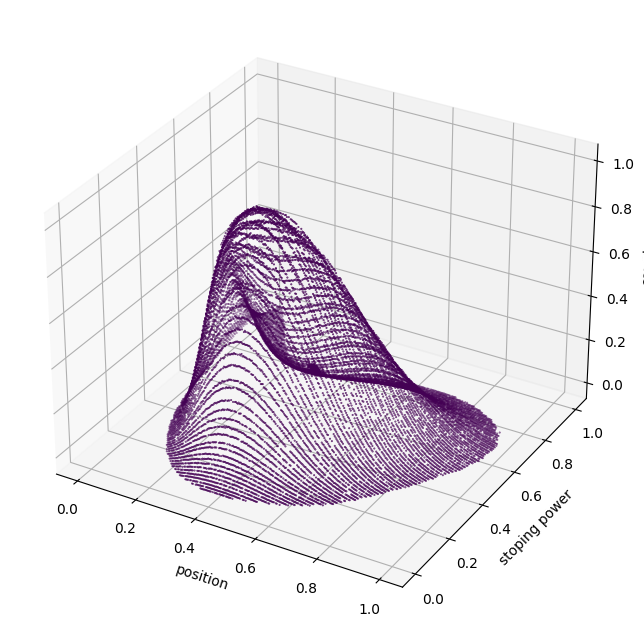

In [90]:
# DBSCAN clustering to see if the points we added will be detected as anomolies

from sklearn.cluster import DBSCAN

feature = stacked_df
sample_size = 50000
graphs = []


if feature.shape[0] <= sample_size :
  print('used full')
  samp_circle = feature
else:
  samp_circle = feature.sample(n=sample_size, random_state=42)
feature_array = samp_circle.values

dbscan = DBSCAN(eps=0.2, min_samples=20)
dbscan.fit(feature_array)
labels = dbscan.labels_

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature_array[:, 0], feature_array[:, 1], feature_array[:, 2], c=labels, cmap='viridis', s=0.2)


ax.set_xlabel("position")
ax.set_ylabel("stoping power")
ax.set_zlabel("count")

graphs.append(fig)
for graph in graphs:
  plt.show()

In [ ]:
# it was clustered together!